Instruction to run the notebook:
1. Download spam.csv with the link https://drive.google.com/file/d/1psCRF8VgjYvathAROxCoGQIo95HEBRIy/view?usp=sharing 

2. Download glove.6B.100d.txt with the link https://drive.google.com/file/d/1lpdPI_wwaSUyezQJnhH00sunlL285e1d/view?usp=sharing 

3. Upload it in the files section in Google collab and Run all cells.

It can take upto 2-3 hours to run all the cells.

In [ ]:
#Importing all the libraries to be used
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import re
import nltk
import sklearn
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import metrics
import xgboost

import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import LSTM, Embedding,BatchNormalization, Dense, TimeDistributed, Dropout, Bidirectional, Flatten, GlobalMaxPool1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
#Loading data
data = pd.read_csv('spam.csv', encoding='ISO-8859-1')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [ ]:
# Dropping the redundent looking collumns (for this project)
to_drop = ["Unnamed: 2","Unnamed: 3","Unnamed: 4"]
data = data.drop(data[to_drop], axis=1)
# Renaming the columns because I feel fancy today 
data.rename(columns = {"v1":"Target", "v2":"Text"}, inplace = True)
data.head

<bound method NDFrame.head of      Target                                               Text
0       ham  Go until jurong point, crazy.. Available only ...
1       ham                      Ok lar... Joking wif u oni...
2      spam  Free entry in 2 a wkly comp to win FA Cup fina...
3       ham  U dun say so early hor... U c already then say...
4       ham  Nah I don't think he goes to usf, he lives aro...
...     ...                                                ...
5567   spam  This is the 2nd time we have tried 2 contact u...
5568    ham              Will Ì_ b going to esplanade fr home?
5569    ham  Pity, * was in mood for that. So...any other s...
5570    ham  The guy did some bitching but I acted like i'd...
5571    ham                         Rofl. Its true to its name

[5572 rows x 2 columns]>

In [ ]:
data.shape

(5572, 2)

EDA

In [ ]:
balance_counts = data.groupby('Target')['Target'].agg('count')
balance_counts

Target
ham     4825
spam     747
Name: Target, dtype: int64

In [ ]:
# Count the number of words in the message
data["num_words"] = data["Text"].apply(lambda s: len(re.findall(r'\w+', s)))

# Get the length of the text message
data["message_len"] = data["Text"].apply(len)

# Count the number of uppercased characters
data["num_uppercase_chars"] = data["Text"].apply(lambda s: sum(1 for c in s if c.isupper())) 

# Count the numbe rof uppercased words
data["num_uppercase_words"] = data["Text"].apply(lambda s: len(re.findall(r"\b[A-Z][A-Z]+\b", s)))

# Check if the message contains the word "free" or "win"
data["contains_free_or_win"] = data["Text"].apply(lambda s: int("free" in s.lower() or "win" in s.lower()))

In [ ]:
data.head()

,Target,Text,num_words,message_len,num_uppercase_chars,num_uppercase_words,contains_free_or_win
0,ham,"Go until jurong point, crazy.. Available only ...",20,111,3,0,0
1,ham,Ok lar... Joking wif u oni...,6,29,2,0,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,33,155,10,2,1
3,ham,U dun say so early hor... U c already then say...,11,49,2,0,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",14,61,2,0,0


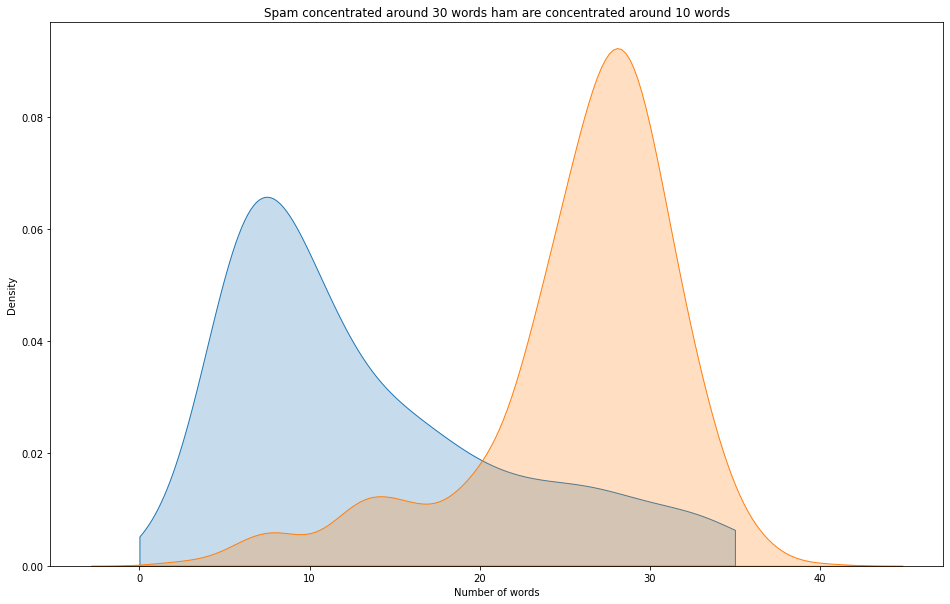

In [ ]:
_,ax = plt.subplots(figsize=(16,10))
sns.kdeplot(data.loc[data.Target == 'ham', "num_words"], shade=True, label="Ham", clip=(0, 35)) 
sns.kdeplot(data.loc[data.Target == 'spam', "num_words"], shade=True, label="Spam")
ax.set(xlabel = "Number of words", ylabel = "Density", title = "Spam concentrated around 30 words ham are concentrated around 10 words")
plt.show()


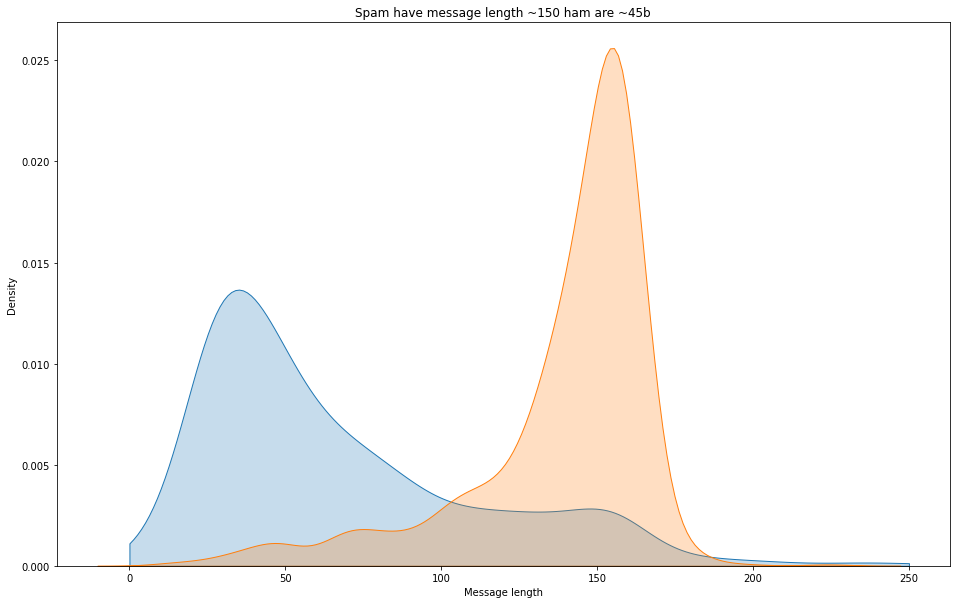

In [ ]:
_,ax = plt.subplots(figsize=(16,10))
sns.kdeplot(data.loc[data.Target == 'ham', "message_len"], shade=True, label="Ham", clip=(0, 250)) # removing observations with message length above 250 because there is an outlier
sns.kdeplot(data.loc[data.Target == 'spam', "message_len"], shade=True, label="Spam")
ax.set(xlabel = "Message length", ylabel = "Density", title = "Spam have message length ~150 ham are ~45b")
plt.show()


Cleaning text

In [ ]:
#Lets have a look at a sample of texts before cleaning
print("\033[1m\u001b[45;1m The First 5 Texts:\033[0m",*data["Text"][:5], sep = "\n")

 The First 5 Texts:
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Ok lar... Joking wif u oni...
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
U dun say so early hor... U c already then say...
Nah I don't think he goes to usf, he lives around here though


In [ ]:
# Defining a function to clean up the text
def Clean(Text):
    sms = re.sub('[^a-zA-Z]', ' ', Text) #Replacing all non-alphabetic characters with a space
    sms = sms.lower() #converting to lowercase
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

data["Clean_Text"] = data["Text"].apply(Clean)
#Lets have a look at a sample of texts after cleaning
print("\033[1m\u001b[45;1m The First 5 Texts after cleaning:\033[0m",*data["Clean_Text"][:5], sep = "\n")

 The First 5 Texts after cleaning:
go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s
u dun say so early hor u c already then say
nah i don t think he goes to usf he lives around here though


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
data["Tokenize_Text"]=data.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)

print("\033[1m\u001b[45;1m The First 5 Texts after Tokenizing:\033[0m",*data["Tokenize_Text"][:5], sep = "\n")

 The First 5 Texts after Tokenizing:
['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'to', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', 'over', 's']
['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say']
['nah', 'i', 'don', 't', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though']


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Removing the stopwords function
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

data["Nostopword_Text"] = data["Tokenize_Text"].apply(remove_stopwords)

print("\033[1m\u001b[45;1m The First 5 Texts after removing the stopwords:\033[0m",*data["Nostopword_Text"][:5], sep = "\n")

 The First 5 Texts after removing the stopwords:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'goes', 'usf', 'lives', 'around', 'though']


LEMMATIZATION



In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
lemmatizer = WordNetLemmatizer()
# lemmatize string
def lemmatize_word(text):
    #word_tokens = word_tokenize(text)
    # provide context i.e. part-of-speech
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

data["Lemmatized_Text"] = data["Nostopword_Text"].apply(lemmatize_word)
print("\033[1m\u001b[45;1m The First 5 Texts after lemitization:\033[0m",*data["Lemmatized_Text"][:5], sep = "\n")


 The First 5 Texts after lemitization:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'get', 'amore', 'wat']
['ok', 'lar', 'joke', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'go', 'usf', 'live', 'around', 'though']


In [ ]:
#Creating a corpus of text feature to encode further into vectorized form
corpus= []
for i in data["Lemmatized_Text"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)
    
corpus[:5]
print("\033[1m\u001b[45;1m The First 5 lines in corpus :\033[0m",*corpus[:5], sep = "\n")

 The First 5 lines in corpus :
go jurong point crazy available bugis n great world la e buffet cine get amore wat
ok lar joke wif u oni
free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply
u dun say early hor u c already say
nah think go usf live around though


In [ ]:
#Changing text data in to numbers. 
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()
#Let's have a look at our feature 
X.dtype

dtype('float64')

In [ ]:
#Label encode the Target and use it as y
label_encoder = LabelEncoder()
data["Target"] = label_encoder.fit_transform(data["Target"])

Steps involved in the Model Building

Setting up features and target as X and y
Splitting the testing and training sets
Build a pipeline of model for four different classifiers.
Naïve Bayes
RandomForestClassifier
KNeighborsClassifier
Support Vector Machines
Fit all the models on training data
Get the cross-validation on the training set for all the models for accuracy

In [ ]:
#Setting values for labels and feature as y and X(we already did X in vectorizing...)
y = data["Target"] 
# Splitting the testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
#Testing on the following classifiers
classifiers = [MultinomialNB(), 
               RandomForestClassifier(),
               KNeighborsClassifier(), 
               SVC(),
              sklearn.linear_model.LogisticRegression(random_state=0),
              sklearn.tree.DecisionTreeClassifier(random_state=0),
              xgboost.XGBClassifier(random_state=0,n_jobs=-1)]
for cls in classifiers:
    cls.fit(X_train, y_train)

# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "NaiveBayes", 1: "RandomForest", 2: "KNeighbours", 3: "SVC", 4: "Logistic Regression", 5: "Decision Tree", 6: "XGBoost"}



In [ ]:
# Cross validation 
for i, model in enumerate(classifiers):
    cv_score = cross_val_score(model, X_train,y_train,scoring="accuracy", cv=10)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

NaiveBayes: 0.966497 
RandomForest: 0.977744 
KNeighbours: 0.911942 
SVC: 0.975829 
Logistic Regression: 0.960514 
Decision Tree: 0.959799 
XGBoost: 0.969130 


In [ ]:
# Model Evaluation
# creating lists of various scores
precision =[]
recall =[]
f1_score = []
trainset_accuracy = []
testset_accuracy = []

for i in classifiers:
    pred_train = i.predict(X_train)
    pred_test = i.predict(X_test)
    prec = metrics.precision_score(y_test, pred_test)
    recal = metrics.recall_score(y_test, pred_test)
    f1_s = metrics.f1_score(y_test, pred_test)
    train_accuracy = i.score(X_train,y_train)
    test_accuracy = i.score(X_test,y_test)
  
    #Appending scores
    precision.append(prec)
    recall.append(recal)
    f1_score.append(f1_s)
    trainset_accuracy.append(train_accuracy)
    testset_accuracy.append(test_accuracy)

In [ ]:
# initialise data of lists.
metrics_table = {'Precision':precision,
'Recall':recall,
'F1score':f1_score,
'Accuracy on Testset':testset_accuracy,
'Accuracy on Trainset':trainset_accuracy}
# Creates pandas DataFrame.
Results = pd.DataFrame(metrics_table, index =["NaiveBayes", "RandomForest", "KNeighbours","SVC", "Logistic Regression", "Decision Tree", "XGBoost"])


In [ ]:
# cmap2 = ListedColormap(["#E2CCFF","#E598D8"])
Results.style.background_gradient()

,Precision,Recall,F1score,Accuracy on Testset,Accuracy on Trainset
NaiveBayes,0.992647,0.706806,0.825688,0.959081,0.976071
RandomForest,1.000000,0.811518,0.895954,0.974156,1.000000
KNeighbours,1.000000,0.392670,0.563910,0.916726,0.925580
SVC,0.987261,0.811518,0.890805,0.972721,0.997846
Logistic Regression,0.960938,0.643979,0.771160,0.947595,0.973199
Decision Tree,0.891429,0.816754,0.852459,0.961235,1.000000
XGBoost,0.970370,0.685864,0.803681,0.954056,0.976549


In [ ]:
!pip install imbalanced-learn

In [ ]:
sns.set_style("darkgrid")
sns.set_context("poster")
plt.rcParams["figure.figsize"] = [8,6]

In [ ]:
from imblearn.over_sampling import SMOTE

su = SMOTE(random_state=42)
X_smote_train, y_smote_train = su.fit_resample(X_train, y_train)

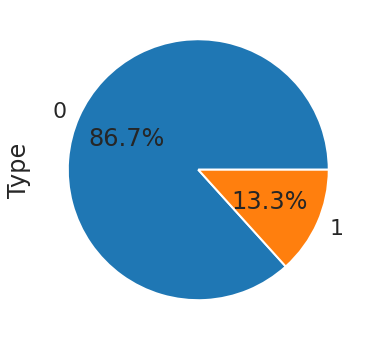

In [ ]:
y_train.groupby(y).size().plot(kind='pie',
                                    y = "y",
                                    label = "Type",
                                    autopct='%1.1f%%')

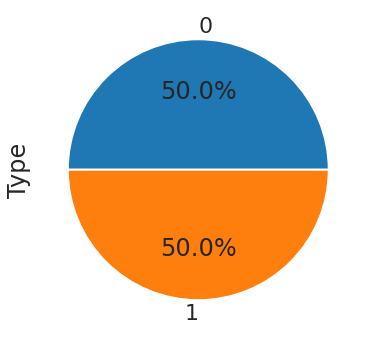

In [ ]:
y_smote_train.groupby(y_smote_train).size().plot(kind='pie',
                                       y = "y_smote_train",
                                       label = "Type",
                                       autopct='%1.1f%%')

In [ ]:
for cls in classifiers:
    cls.fit(X_smote_train, y_smote_train)

In [ ]:
# Crossvalidation 
for i, model in enumerate(classifiers):
    cv_score = cross_val_score(model, X_smote_train, y_smote_train, scoring="accuracy", cv=10)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

NaiveBayes: 0.979852 
RandomForest: 0.994344 
KNeighbours: 0.994204 
SVC: 0.997793 
Logistic Regression: 0.986478 
Decision Tree: 0.976404 
XGBoost: 0.972955 


In [ ]:
# Model Evaluation
# creating lists of varios scores
precision =[]
recall =[]
f1_score = []
trainset_accuracy = []
testset_accuracy = []

for i in classifiers:
    pred_train = i.predict(X_smote_train)
    pred_test = i.predict(X_test)
    prec = metrics.precision_score(y_test, pred_test)
    recal = metrics.recall_score(y_test, pred_test)
    f1_s = metrics.f1_score(y_test, pred_test)
    train_accuracy = i.score(X_smote_train, y_smote_train)
    test_accuracy = i.score(X_test,y_test)
  
    #Appending scores
    precision.append(prec)
    recall.append(recal)
    f1_score.append(f1_s)
    trainset_accuracy.append(train_accuracy)
    testset_accuracy.append(test_accuracy)

In [ ]:
# initialise data of lists.
metrics_table = {'Precision':precision,
'Recall':recall,
'F1score':f1_score,
'Accuracy on Testset':testset_accuracy,
'Accuracy on Trainset':trainset_accuracy}
# Creates pandas DataFrame.
Results = pd.DataFrame(metrics_table, index =["NaiveBayes", "RandomForest", "KNeighbours","SVC", "Logistic Regression", "Decision Tree", "XGBoost"])


In [ ]:
# cmap2 = ListedColormap(["#E2CCFF","#E598D8"])
Results.style.background_gradient()

,Precision,Recall,F1score,Accuracy on Testset,Accuracy on Trainset
NaiveBayes,0.852381,0.937173,0.892768,0.969131,0.987441
RandomForest,1.000000,0.816754,0.899135,0.974874,1.000000
KNeighbours,0.977444,0.680628,0.802469,0.954056,0.998344
SVC,0.993671,0.821990,0.899713,0.974874,1.000000
Logistic Regression,0.937143,0.858639,0.896175,0.972721,0.991306
Decision Tree,0.795122,0.853403,0.823232,0.949749,1.000000
XGBoost,0.796954,0.821990,0.809278,0.946877,0.978747


BERT and GLOVE with LSTM

In [ ]:
df = pd.DataFrame(corpus, columns =['text'])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df['text'], y, test_size=0.25, random_state=42)

In [ ]:
embedding_dict = dict()
embedding_dim = 100

# Each word is represented in one line in the text file
# Format - Word val1 val2 val3......val-n for n-dimension vector space

with open('glove.6B.100d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector = np.asarray(records[1:], dtype='float32')
        embedding_dict[word] = vector

In [ ]:
text = df['text']

In [ ]:
# Calculating the total vocabulary
tk = Tokenizer()
tk.fit_on_texts(text)

vocab = len(tk.word_index)+1
vocab

6597

In [ ]:
# Maximum length
max_len = np.max(df['text'].apply(lambda x: len(x.split())).values)
max_len


77

In [ ]:
def embedding(text):
    return tk.texts_to_sequences(text)

train_padded = pad_sequences(embedding(text), 77, padding='post')

In [ ]:
# Creating a matrix for each word as index (word numerical value extracted from tokenizer
# with N-features (corresponding to GloVe)
# We will replace the matrix elements by the words and their embeddings

# Our embeddings will also consist embeddings for padding
embedding_matrix = np.zeros((vocab, embedding_dim))

for word, index in tk.word_index.items():
    embed_vector = embedding_dict.get(word)
    if embed_vector is not None:
        embedding_matrix[index] = embed_vector
        
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.031087  ,  0.22155   ,  0.44494   , ..., -0.67097002,
         0.24698   , -0.62001002],
       [ 0.14432999,  0.43950999,  0.58323997, ...,  0.50133997,
         0.49535999,  0.49919999],
       ...,
       [ 0.63009   , -0.036992  ,  0.24052   , ...,  0.10029   ,
         0.056822  ,  0.25018999],
       [-0.12201   ,  0.20465   ,  0.53192002, ..., -0.164     ,
        -0.41637   ,  0.66426003],
       [-0.41600999,  0.16974001,  0.43457001, ..., -0.083432  ,
         0.49520999,  0.77258003]])

In [ ]:
# We will be creating seaborn and plotly confusion matrices
import plotly.figure_factory as ff
x_axes = ['Safe','Spam']
y_axes = ['Spam', 'Safe']

def conf_matrix(z, x=x_axes, y=y_axes):
    z = np.flip(z, 0)
    # Change each element of z to string 
    # This allows them to be used as annotations
    z_str = [[str(y) for y in x] for x in z]
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_str)
    
    fig.update_layout(title_text='Confusion matrix', xaxis=dict(title='Predicted Value'),
                     yaxis=dict(title='Real value'))
    
    fig['data'][0]['showscale'] = True
    return fig

In [ ]:
from sklearn.metrics import confusion_matrix
categories=['Ham', 'Spam']
def seaborn_conf(y, ypred):
    y_true = ["Ham", "Spam"]
    y_pred = ["Ham", "Spam"]
    cf = confusion_matrix(y, ypred)
    df_cm = pd.DataFrame(cf, columns=np.unique(y_true), index = np.unique(y_true))
    plt.figure(figsize=(8,6))
    sns.heatmap(df_cm, annot=True, fmt='g')
    plt.title('Confusion matrix')
    plt.xlabel('Predicted value')
    plt.ylabel('Real value')
    plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train_padded, y, test_size=0.25)

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                   output_dim=embedding_matrix.shape[1],
                   weights=[embedding_matrix],
                   input_length=max_len
                   )
         )
model.add(Bidirectional(LSTM(max_len, return_sequences=True, recurrent_dropout=0.15)))
model.add(GlobalMaxPool1D())
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(max_len, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(max_len, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 77, 100)           659700    
                                                                 
 bidirectional (Bidirectiona  (None, 77, 154)          109648    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 154)              0         
 lMaxPooling1D)                                                  
                                                                 
 batch_normalization (BatchN  (None, 154)              616       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 154)               0         
                                                        

In [ ]:
x_train.shape

In [ ]:
# Defining Callbacks
# Checkpoints in case our model stops training due to some circumstance - saving progress
checkpoints = ModelCheckpoint('ck_model.h5', monitor='val_loss', verbose=1, save_best_only=True)
# Reducing the learning rate if no improvement in validation loss over 5 epochs
# This is to train the model better
reduce_lr = ReduceLROnPlateau(monitor='val_loss', vactor=0.1, verbose=1, patience=5, min_lr=0.0001)

In [ ]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test), verbose=1, callbacks=[reduce_lr, checkpoints])


Epoch 1/10
131/131 [==============================] - ETA: 0s - loss: 0.2221 - accuracy: 0.9062
Epoch 1: val_loss improved from inf to 0.24244, saving model to ck_model.h5
131/131 [==============================] - 73s 500ms/step - loss: 0.2221 - accuracy: 0.9062 - val_loss: 0.2424 - val_accuracy: 0.9612 - lr: 0.0010
Epoch 2/10
131/131 [==============================] - ETA: 0s - loss: 0.0865 - accuracy: 0.9727
Epoch 2: val_loss improved from 0.24244 to 0.11133, saving model to ck_model.h5
131/131 [==============================] - 65s 496ms/step - loss: 0.0865 - accuracy: 0.9727 - val_loss: 0.1113 - val_accuracy: 0.9670 - lr: 0.0010
Epoch 3/10
131/131 [==============================] - ETA: 0s - loss: 0.0490 - accuracy: 0.9837
Epoch 3: val_loss improved from 0.11133 to 0.06571, saving model to ck_model.h5
131/131 [==============================] - 63s 478ms/step - loss: 0.0490 - accuracy: 0.9837 - val_loss: 0.0657 - val_accuracy: 0.9770 - lr: 0.0010
Epoch 4/10
131/131 [===============

In [ ]:
# Plotting the results
def learning_curve(history, arr):
    fig, ax=plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]])
        ax[idx].set_xlabel('Epochs')
        ax[idx].set_ylabel('Value')
        ax[idx].set_title(arr[idx][0]+' X '+ arr[idx][1])

In [ ]:
yp = model.predict(x_test)
yp

array([[7.0863388e-02],
       [2.3264181e-05],
       [2.1884866e-06],
       ...,
       [3.1632787e-12],
       [1.8600340e-04],
       [1.5186504e-07]], dtype=float32)

In [ ]:
yp = (model.predict(x_test)>0.5).astype('int32')
yp

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int32)

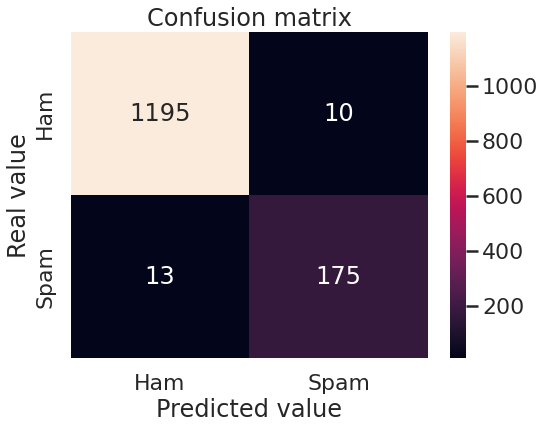

In [ ]:
seaborn_conf(y_test, yp)


In [ ]:
!pip install transformers

     |████████████████████████████████| 4.2 MB 4.1 MB/s 
     |████████████████████████████████| 596 kB 70.5 MB/s 
     |████████████████████████████████| 6.6 MB 52.3 MB/s 
     |████████████████████████████████| 84 kB 4.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

def bert_encode(data, maximum_length):
    input_ids=[]
    attention_masks=[]
    for text in data:
        encoded = tokenizer.encode_plus(text, add_special_tokens=True, max_length = maximum_length, pad_to_max_length=True, return_attention_mask=True)
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

In [ ]:
np.max(df['text'].apply(lambda x: len(x.split())).values)


77

In [ ]:
bt_text = df['text']
bt_label = y

bt_ids, bt_masks = bert_encode(bt_text, 77)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
from transformers import TFBertModel
def create_model(bert_model):
    
    input_ids = tf.keras.Input(shape=(77,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(77,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
model = create_model(bert_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 77)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 77)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 77,                                            

In [ ]:
history = model.fit([bt_ids, bt_masks], bt_label, validation_split=0.25, epochs=3, batch_size=10)

Epoch 1/3
418/418 [==============================] - 89s 168ms/step - loss: 0.1279 - accuracy: 0.9605 - val_loss: 0.0457 - val_accuracy: 0.9835
Epoch 2/3
418/418 [==============================] - 64s 154ms/step - loss: 0.0529 - accuracy: 0.9854 - val_loss: 0.0418 - val_accuracy: 0.9878
Epoch 3/3
418/418 [==============================] - 65s 155ms/step - loss: 0.0309 - accuracy: 0.9935 - val_loss: 0.0377 - val_accuracy: 0.9899


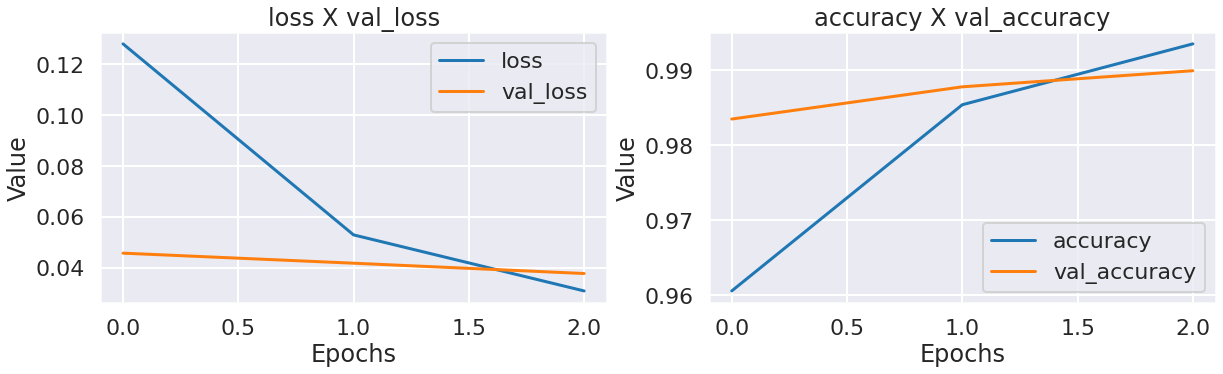

In [ ]:
learning_curve(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])
